# Определение перспективного тарифа для телеком-компании

Я выступаю в роли аналитика компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

**Цели проекта**

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моём распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше, а также проверить гипотезы о разнице в выручке между клиентами двух тарифов и отличии клиентов из Москвы и других регионов.

**Структура проекта**

**1. Изучение и предобработка данных**
* посмотресть на набор данных
* сделать предварительные выводы

**2. Подготовка данных**

* привести данные к нужным типам
* найти и исправить ошибки в данных, если они есть

Посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя

**3. Анализ данных**

Опишите поведение клиентов оператора, исходя из выборки:
* сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа
в месяц? 
* посчитайте среднее количество, дисперсию и стандартное отклонение
* постройте гистограммы. Опишите распределения

**4. Проверка гипотез**

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Пороговое значение alpha задайте самостоятельно.
Поясните:
* как вы формулировали нулевую и альтернативную гипотезы;
* какой критерий использовали для проверки гипотез и почему.

**5. Результаты исследования**

* общие выводы

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from datetime import datetime
import math

import copy

In [2]:
#Добавлю форматтинг для улучшения визуального отображения
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

## Обзор данных

In [3]:
# Чтение исходных данных
data_users, data_calls, data_messages, data_internet, data_tariffs = (
    pd.read_csv('https://code.s3.yandex.net/datasets/users.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv'),
    pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv'),
)

### Изучение данных

#### Изучение таблицы `users`

In [4]:
data_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
data_users.tail(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [6]:
data_users.describe()

,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


In [7]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В датафрейме по пользователям есть пропуски в колонке `churn_date` - дата прекращения пользования тарифом, пропуски означают, что тариф действует на момент выгрузки. Соответственно, пропуски можно заменить на нули. При изменении типов данных нужно будет изменить тип в колонке `reg_date`.

#### Изучение таблицы `calls`

In [8]:
data_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
data_calls.tail(5)

,id,call_date,duration,user_id
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


In [10]:
data_calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


In [11]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В описании к заданию указано, что все звонки округляются до минут - сделаю при предобработке. В данных есть строки с нулевыми значениями - это входящие звонки, изменю тип в колонке дата звонка для дальнейшего анализа.

#### Изучение таблицы `messages`

In [12]:
data_messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
data_messages.tail(5)

,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


In [14]:
data_messages.describe()

,user_id
count,"123,036.00"
mean,"1,256.99"
std,143.52
min,"1,000.00"
25%,"1,134.00"
50%,"1,271.00"
75%,"1,381.00"
max,"1,499.00"


In [15]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


#### Изучение таблицы `internet`

In [16]:
data_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [17]:
data_internet.tail(5)

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,"1,246.32",2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [18]:
data_internet.describe()

,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


In [19]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В описании к заданию указано, что все мегабайты округляются до гигабайт, в данных есть строки с нулевыми значениями - интересно кто сейчас не пользуется интернетом.

#### Изучение таблицы `tariffs`

In [20]:
data_tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод обзора данных

Данные выглядят корректными на вход, есть отдельные столбцы, в которых нужно поменять тип данных, округлить значения к большему числу (минут и гигабайты)

## Подготовка данных

### Изменение типов данных и исправление ошибок 

In [22]:
# Изменение типа данных в колонке дата reg_date и churn_date
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')

data_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [23]:
# Проверю применение изменений в датафрейме
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [61]:
# Изменение типа данных в колонке дата звонка
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
# Округлю звонки до минуты методом ceil, так как по условию оператир округляет секунды до минут 
data_calls['duration'] = np.ceil(data_calls['duration']).astype('int')

#Выведу первые 5 строк для проверки изменений:
data_calls.head(5)

,id,call_date,duration,user_id,month,calls_count
0,1000_0,2018-07-25,0,1000,7,0
1,1000_1,2018-08-17,0,1000,8,0
2,1000_2,2018-06-11,3,1000,6,1
3,1000_3,2018-09-21,14,1000,9,1
4,1000_4,2018-12-15,6,1000,12,1


In [25]:
# Проверю применение изменений в датафрейме
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


In [26]:
# Изменение типа данных в колонке дата сообщения
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')

#Выведу первые 5 строк для проверки изменений:
data_messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [27]:
# Проверю применение изменений в датафрейме
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [28]:
# Изменение типа данных в колонке дата сессии
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

#Выведу первые 5 строк для проверки изменений:
data_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [29]:
# Проверю применение изменений в датафрейме
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [30]:
data_internet.describe()

,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


In [31]:
# Добавлю в датафрейм с описанием тарифов колонку с переводом лимит мегабайт в гигабайты:
data_tariffs['gb_per_month_included'] = data_tariffs['mb_per_month_included'] / 1024
data_tariffs['gb_per_month_included'] = data_tariffs['gb_per_month_included'].astype('int')

# Проверю полученный резульат:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


### Дополнительные расчёты:
1. количество сделанных звонков и израсходованных минут разговора по месяцам;
2. количество отправленных сообщений по месяцам;
3. объем израсходованного интернет-трафика по месяцам;
4. помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

#### Количество звонков и израсходованные минуты по месяцам

In [32]:
# Добавлю колонку с месяцем:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

#Добавлю в таблицу счётчик звонков для позиций с ненулевой продолжительностью
data_calls['calls_count'] = 1
data_calls.loc[(data_calls['duration'] ==0), 'calls_count'] = 0

# Агрегирую датафрейм по клиентам, месяцу и посчитаю длительность звоков и их количество:
data_calls_grouped = data_calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'calls_count':'sum'}).reset_index()

# Выведу полученные данные:
data_calls_grouped.head(5)

,user_id,month,duration,calls_count
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46


#### Количество отправленных сообщений по месяцам

In [33]:
# Добавлю колонку с месяцем:
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month

# Агрегирую датафрейм по клиентам, месяцу и посчитаю количество сообщений:
data_messages_grouped = data_messages.groupby(['user_id', 'month'])\
                                    .agg({'id':'count'}).reset_index()\
                                    .rename(columns={'id':'message_count'})
data_messages_grouped.head(5)

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Объем израсходованного интернет-трафика по месяцам

In [34]:
# Добавлю колонку с месяцем:
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

# Агрегирую датафрейм по клиентам, месяцу и посчитаю количество сообщений:
data_internet_grouped = data_internet.groupby(['user_id', 'month'])\
                                    .agg({'mb_used':'sum'}).reset_index()

data_internet_grouped['gb_used'] = data_internet_grouped['mb_used'] / 1024 
data_internet_grouped['gb_used'] = data_internet_grouped['gb_used'].apply(np.ceil).astype('int')
data_internet_grouped.head(4)

,user_id,month,mb_used,gb_used
0,1000,5,"2,253.49",3
1,1000,6,"23,233.77",23
2,1000,7,"14,003.64",14
3,1000,8,"14,055.93",14


#### Помесячная выручка с каждого пользователя 

Для расчёта необходимо: 
1. вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
2. остаток умножить на значение из тарифного плана
3. прибавить абонентскую плату, соответствующую тарифному плану.

In [35]:
# соберу все 5 датафреймов в один для удобства дальнейшей работы с одной переменной и выполнения расчётов:
data_grouped = data_calls_grouped.merge(data_messages_grouped, on=['user_id', 'month'], how='outer')\
                                .merge(data_internet_grouped, on=['user_id', 'month'],  how='outer')\
                                .merge(data_users, on='user_id', how='left')\
                                .merge(data_tariffs, left_on='tariff', right_on='tariff_name', how='left')

# Проверю полученный датафрейм методом info()
data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   duration               3174 non-null   float64       
 3   calls_count            3174 non-null   float64       
 4   message_count          2717 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   gb_used                3203 non-null   float64       
 7   age                    3214 non-null   int64         
 8   churn_date             187 non-null    datetime64[ns]
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

В датафрейме появились пустые значения в колонках со звонками, сообщениями и интернет трафиком. Пустые значения возникли из-за того, что пользователь мог не пользоваться каким-то из 3 типов коммуникаций в определённый месяц или в целом. Заменю пропуски на нули.

In [36]:
# Замена пропусков на нули:
data_grouped['duration'] = data_grouped['duration'].fillna(0).astype('int')
data_grouped['calls_count'] = data_grouped['calls_count'].fillna(0).astype('int')
data_grouped['message_count'] = data_grouped['message_count'].fillna(0).astype('int')
data_grouped['gb_used'] = data_grouped['gb_used'].fillna(0).astype('int')

# Переведу мегабайты из датафрейма с описанием тарифа в  
data_grouped = data_grouped[['user_id', 'month', 'duration', 'calls_count', 'message_count', 'gb_used', 
        'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff', 
        'minutes_included', 'messages_included', 'gb_per_month_included',
        'rub_monthly_fee', 'rub_per_minute', 'rub_per_message', 'rub_per_gb']]

# Проверка замен:
data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   duration               3214 non-null   int32         
 3   calls_count            3214 non-null   int32         
 4   message_count          3214 non-null   int32         
 5   gb_used                3214 non-null   int32         
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  min

In [37]:
# напишу функцию для расчёте помесячной выручки:
def revenue_above(row):
    mins = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    sms = (row['message_count'] - row['messages_included']) * row['rub_per_message']
    internet = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
    revenue = 0
    for value in [mins, sms, internet]:
        if value > 0:
            revenue += value
    return revenue

In [38]:
# Применю функцию к датафрейму:
data_grouped['revenue_above'] = data_grouped.apply(lambda x: revenue_above(x), axis=1)
# Добавлю расчёт выручки по каждому пользователю в месяц:
data_grouped['revenue_per_user'] = data_grouped['rub_monthly_fee'] + data_grouped['revenue_above'] 
data_grouped.head(3)

,user_id,month,duration,calls_count,message_count,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,minutes_included,messages_included,gb_per_month_included,rub_monthly_fee,rub_per_minute,rub_per_message,rub_per_gb,revenue_above,revenue_per_user
0,1000,5,159,17,22,3,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,1000,30,1950,1,1,150,0,1950
1,1000,6,172,28,60,23,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,1000,30,1950,1,1,150,0,1950
2,1000,7,340,41,75,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,1000,30,1950,1,1,150,0,1950


In [39]:
# После завершения предобработки перезапишу датафрейм в новую переменную, старую сохраню в качестве бэкапа. 
data = copy.deepcopy(data_grouped)

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки:
* сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа
в месяц? 
* посчитайте среднее количество, дисперсию и стандартное отклонение
* постройте гистограммы. Опишите распределения


In [40]:
# Посмотрю на полученные результаты в части выручки на 1 пользователя:
data[['revenue_per_user']].describe()

,revenue_per_user
count,"3,214.00"
mean,"1,529.08"
std,798.25
min,550.00
25%,750.00
50%,"1,653.50"
75%,"1,950.00"
max,"6,770.00"


Среднее и медианы не сильно отличаются друг от друга - 1529 и 1653 соответственно. Есть пользователи, которые хотя бы один месяц не превышали пакетный лимит пакет, а также есть пользователи в разы превышающие лимиты.

In [41]:
# Разбивка массива по тарифам:
data['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

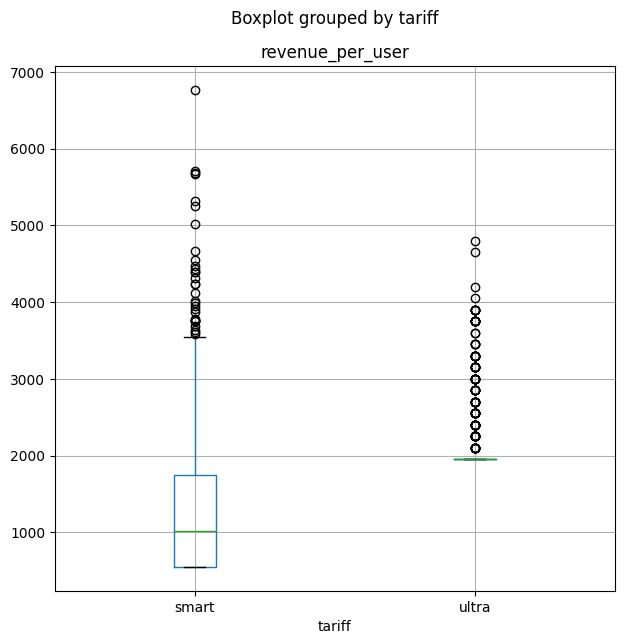

In [42]:
# Построю диаграммы размаха по выручке в разрезе тарифов:
data.boxplot('revenue_per_user', by='tariff', figsize=(7, 7))
plt.show()

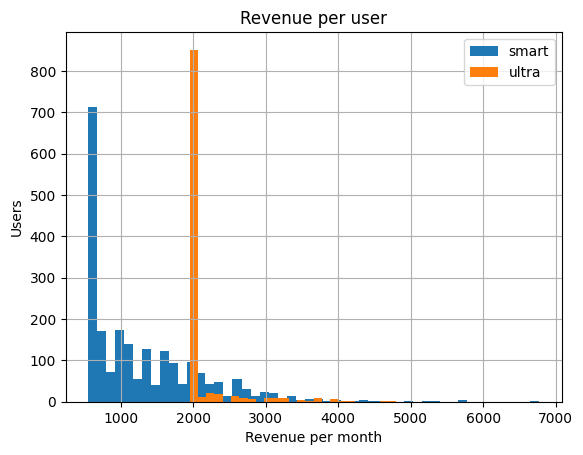

In [43]:
# Построю гистограммы и сравню графики:
data[data['tariff'] == 'smart']['revenue_per_user'].plot(kind='hist', 
                                                         bins=50, 
                                                         label='smart', 
                                                         grid=True,
                                                         legend=True)
plt.xlabel('Revenue per month')
plt.ylabel('Users')

data[data['tariff'] == 'ultra']['revenue_per_user'].plot(kind='hist', 
                                                         bins=25, 
                                                         label='ultra', 
                                                         grid=True,
                                                         title='Revenue per user',
                                                         legend=True)
plt.xlabel('Revenue per month')
plt.ylabel('Users')
plt.show()

In [44]:
# Сгруппирую датафрейм по тарифам:
data.groupby('tariff').agg({'revenue_per_user':['sum', 'count', 'median', 'mean', 'min', 'max', 'var', 'std']})

revenue_per_user                                                      
                    sum count   median     mean   min   max        var    std
tariff                                                                       
smart           2875351  2229 1,023.00 1,289.97   550  6770 669,785.71 818.40
ultra           2039100   985 1,950.00 2,070.15  1950  4800 141,516.75 376.19

**Вывод:**

Пользователи тарифов ведут себя схожим образом в части использования пакетного лимита, с одной особенностью - пользователи тарифа smart, среднем чуть больше выходят за рамки лимитов, чем пользователи тарифа ultra.

### Минуты разговора в разбивке по тарифам

In [45]:
data.groupby('tariff').agg({'duration':['median', 'mean', 'var', 'std']})

duration                         
         median   mean        var    std
tariff                                  
smart    422.00 417.93  36,219.32 190.31
ultra    518.00 526.62 100,873.63 317.61

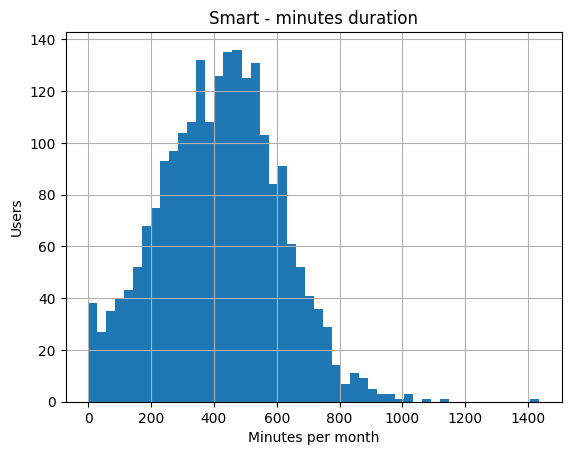

median =  422.0


In [46]:
data[data['tariff'] == 'smart']['duration'].plot(kind='hist', bins=50, title='Smart - minutes duration', grid=True)
plt.xlabel('Minutes per month')
plt.ylabel('Users')
plt.show()

print('median = ', data[data['tariff'] == 'smart']['duration'].median())

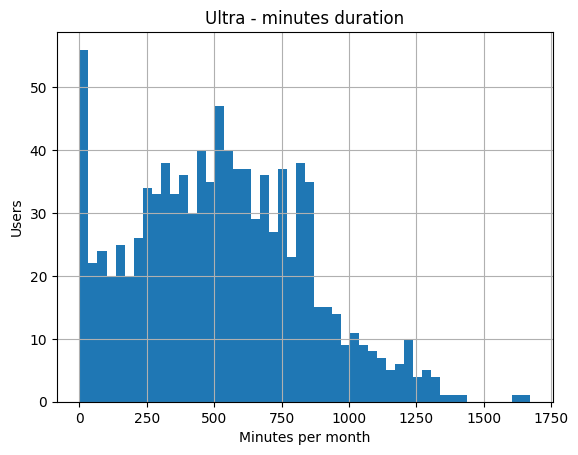

median =  518.0


In [47]:
data[data['tariff'] == 'ultra']['duration'].plot(kind='hist', bins=50, title='Ultra - minutes duration', grid=True)
plt.xlabel('Minutes per month')
plt.ylabel('Users')
plt.show()

print('median = ', data[data['tariff'] == 'ultra']['duration'].median())

**Вывод:**

Гистограмма распределения минут в тарифе smart соответствует нормальному случайному распределению. В обоих тарифах есть всплеск в районе 0 минут - это пропущенные звонки, их не нужно удалять.
Медианное значение минут на тарифе smart равно 422 минутам в месяц, выбирая почти весь лимит (500 минут). Медианное значение на тарифе ultra равно 518 минутам при лимите в 3000 минут, таким образом, остаётся существенный запас.
Из-за значительного запаса по минутам в пакете гистограмма тарифа ultra не выглядит как случайное нормальное распределение.

**Дисперсии** и **Стандартные отклонения** по обоим тарифам большие - это говорит о том, что значения в выборках сильно отличаются от математических ожиданий и средних арифметических по каждой из выборок соответственно.

### Количество сообщений в разбивке по тарифам

In [48]:
data.groupby('tariff').agg({'message_count':['median', 'mean', 'var', 'std']})

message_count                     
              median  mean      var   std
tariff                                   
smart          28.00 33.38   796.81 28.23
ultra          38.00 49.36 2,285.27 47.80

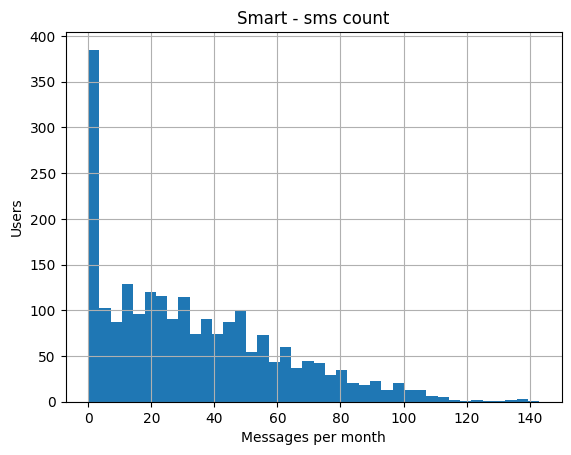

median =  28.0


In [49]:
data[data['tariff'] == 'smart']['message_count'].plot(kind='hist', bins=40, title='Smart - sms count', grid=True)
plt.xlabel('Messages per month')
plt.ylabel('Users')
plt.show()

print('median = ', data[data['tariff'] == 'smart']['message_count'].median())

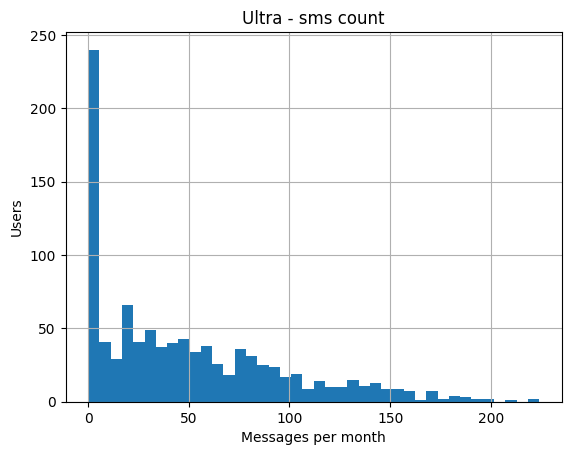

median =  38.0


In [50]:
data[data['tariff'] == 'ultra']['message_count'].plot(kind='hist', bins=40, title='Ultra - sms count', grid=True)
plt.xlabel('Messages per month')
plt.ylabel('Users')
plt.show()

print('median = ', data[data['tariff'] == 'ultra']['message_count'].median())

**Вывод:**
Гистограммы распределения сообщений в тарифах выглядят схожими. Основной тренд на отказ клиентами от общения через смс, что выглядит логичным в эпоху развития мессенджеров. 

### Пакет интернет трафика в разбивке по тарифам

In [51]:
data.groupby('tariff').agg({'gb_used':['median', 'mean', 'var', 'std']})

gb_used                 
        median  mean   var  std
tariff                         
smart    17.00 16.33 33.03 5.75
ultra    19.00 19.49 97.09 9.85

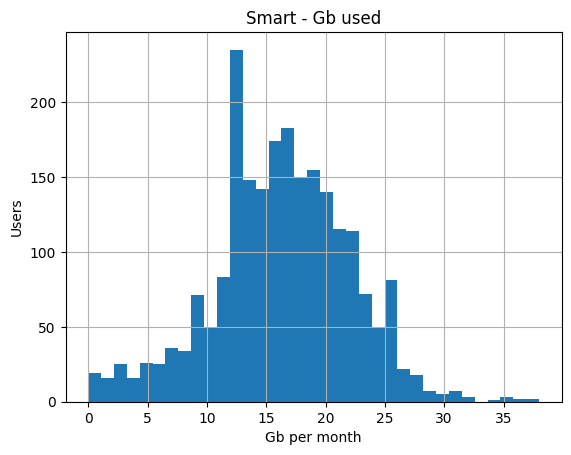

median =  17.0


In [52]:
data[data['tariff'] == 'smart']['gb_used'].plot(kind='hist', bins=35, title='Smart - Gb used', grid=True)
plt.xlabel('Gb per month')
plt.ylabel('Users')
plt.show()

print('median = ', data[data['tariff'] == 'smart']['gb_used'].median())

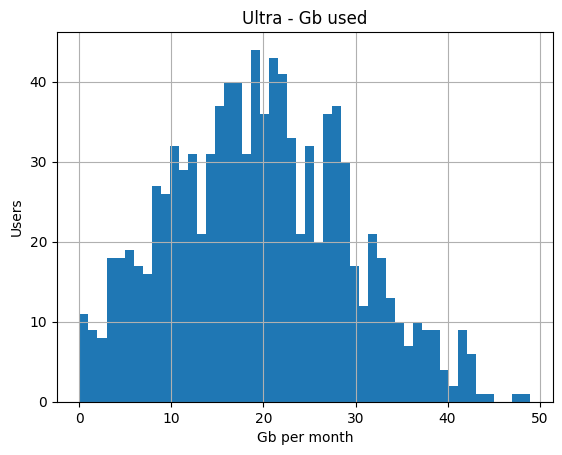

median =  19.0


In [53]:
data[data['tariff'] == 'ultra']['gb_used'].plot(kind='hist', bins=50, title='Ultra - Gb used', grid=True)
plt.xlabel('Gb per month')
plt.ylabel('Users')
plt.show()

print('median = ', data[data['tariff'] == 'ultra']['gb_used'].median())

**Вывод:**
Гистограммы распределения по интернет трафику соответствуют нормальным случайным распределениям, в тарифе ultra - отдельно отмечу пользователей, не использовавшие интернет за месяц - редкость в наши дни.
Также отмечу, что клиенты на тарифе smart ненамного меньше используют интернет (17 Gb), чем в тарифе ultra (19 Gb). При том, что пакетные лимиты отличаются в 2 раза (15 Gb против 30 Gb соответственно). Оператору стоит обратить на это внимание.

## Проверка гипотез

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Пороговое значение alpha задайте самостоятельно.
Поясните:
* как вы формулировали нулевую и альтернативную гипотезы;
* какой критерий использовали для проверки гипотез и почему.

### Средняя выручка пользователей тарифов

Буду использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.

Гипотеза о равенстве средних двух генеральных совокупностей №1

Сформулирую гипотезы:

* H0: выручка пользователей тарифов «Смарт» и «Ультра» не различается
* H1: выручка пользователей тарифов «Смарт» и «Ультра» различается

In [54]:
# Введу переменные для проведения теста
smart = data[data['tariff'] == 'smart'][['revenue_per_user']]
ultra = data[data['tariff'] == 'ultra'][['revenue_per_user']]

# Проведение теста, задам критический уровень статистиеской значимости в 5%
alpha = 0.05
results = st.ttest_ind(smart, ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [1.42298144e-160]
Отвергаем нулевую гипотезу


**Вывод:**

Между выборками есть статистически значимые различия.

###  Средняя выручка пользователей из Москвы и из других регионов

Гипотеза о равенстве средних двух генеральных совокупностей №2

Сформулируем гипотезы:

* H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
* H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [55]:
# Посмотрю уникальные населённые пункты в датафрейме
data['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [56]:
# Добавлю колонку, в которой разделю Москву и остальные населённые пункты
data['region'] = np.where(data['city'] == 'Москва', 'Москва', 'Другой Регион')
moscow = data[data['region'] == 'Москва'][['revenue_per_user']]
region_other = data[data['region'] == 'Другой Регион'][['revenue_per_user']]

# Проведение теста, задам критический уровень статистиеской значимости в 5%
alpha = 0.05

results = st.ttest_ind(moscow, region_other)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [0.54401529]
Не получилось отвергнуть нулевую гипотезу


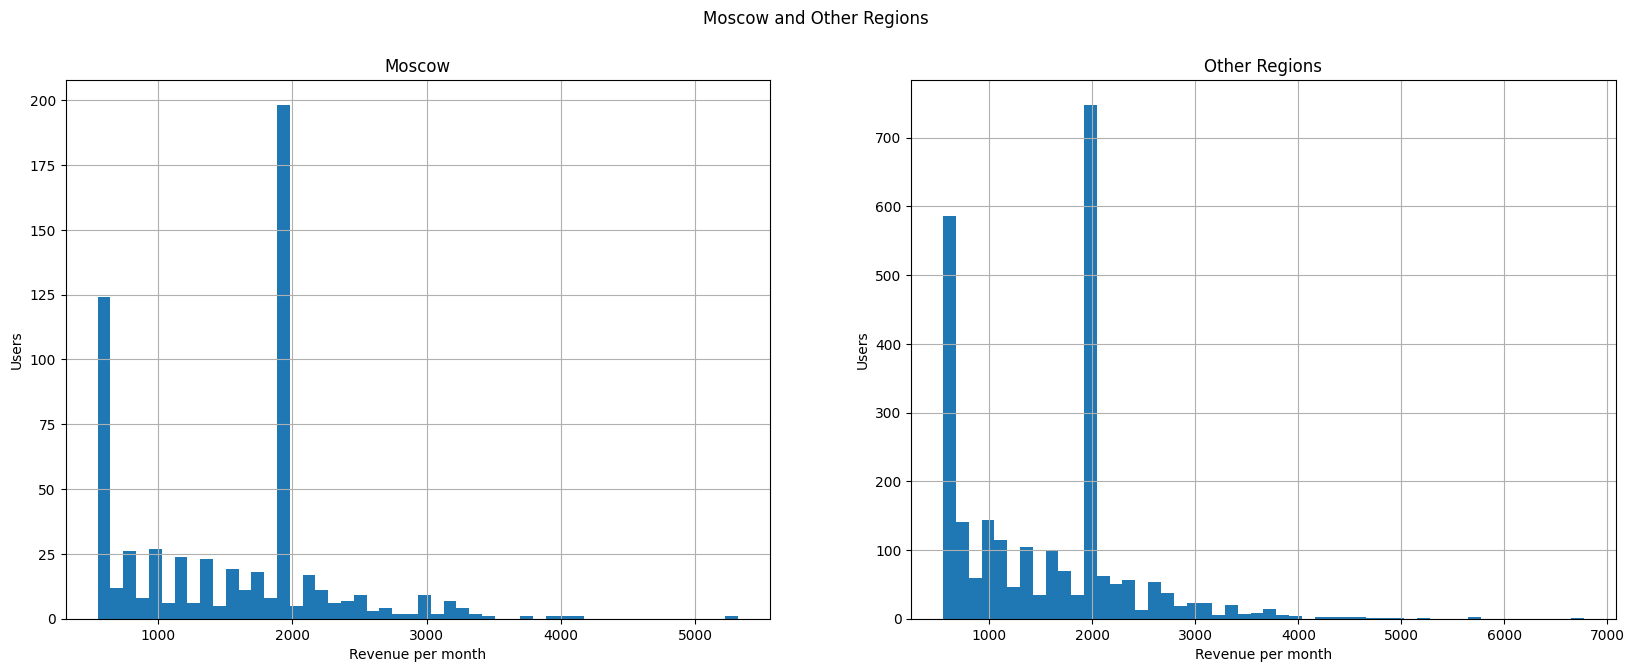

In [67]:
# Построю гистограммы для визуализации данных
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Moscow and Other Regions')

ax_1 = plt.subplot(1, 2, 1)
moscow.plot(kind='hist', bins=50, grid=True, legend=False, title='Moscow', ax=ax_1)
plt.xlabel('Revenue per month')
plt.ylabel('Users')

ax_2 = fig.add_subplot(1, 2, 2)
region_other.plot(kind='hist', bins=50, grid=True, legend=False, title='Other Regions', ax=ax_2)
plt.xlabel('Revenue per month')
plt.ylabel('Users')

plt.show()

**Вывод:**

С вероятностью в 30% результат может быть получен случайно. Между выборками статистически значимых различий нет.

## Результаты исследования

**Описание данных**

Для проведения исследования использовались 5 баз данных:
* 2 "описательные" таблицы с описанием пользователей и тарифов,
* 3 "количественные" таблицы с количеством и продолжительностью звонков, количеством смс и интернет трафиком в разрезе пользователей и даты.

**Предобработка данных**

В ходе предобработки данных были выполнены следущие шаги:
1. изменил типы данных в колонках с датами во всех датафреймах для дальнейшей работы с ними, 
2. перевёл секунды разговора в минуты с округлением вверх и аналогично Mb в Gb. 
3. по всем "количественным" таблицам сгруппировал данные (кол-во и продолжительность звонков, кол-во смс и израсходованный интернет трафик) по пользователям и месяцам. 
4. объединил все датафреймы в один и заменил появившиес пропуски на нули
5. расчитал выручку на каждого пользователя с учётом стоимости пакетного тарифа и фактических превышений пакетных лимитов тарифа.

**Анализ данных**

При анализе данных было выявлено, что пользователи тарифа smart почти полностью выбирают пакет минут и в среднем чуть превышают интернет лимит в пакете.  

При стоимости тарифа в 550 руб. медианное значение выручки составляет 1023 р., по сравнению с тарифом ultra, где при стоимости тарифа в 1950 руб., медианное значение выручки составляет 1950 руб. 

На диаграммах размаха присутствует сравнительно большие выбросы (значения выше 3 квартиля * 1.5) связано с использованием интернета и указывают на несбалансированность тарифа.

С точки зрения выручки для оператора, тариф smart является более выгодным, так как валово приносит больше денег. Но, возможно, если смотреть на экономику дальше, то прибыль будет распределяться по-другому. 
Также возникает вопрос, насколько тариф является привлекательным с точки зрения переманивания на него пользователей других операторов (постоянно находиться в режиме жёстких ограничений не всем подойдёт). А также насколько довольны текущиие пользователи. Но эти вопросы за рамками текущего исслеования.

In [58]:
# Сгруппирую датафрейм по тарифам:
data.groupby('tariff').agg({'revenue_per_user':['sum','count', 'median', 'mean']})

revenue_per_user                        
                    sum count   median     mean
tariff                                         
smart           2875351  2229 1,023.00 1,289.97
ultra           2039100   985 1,950.00 2,070.15

### Проверка гипотез - вывод

При проведении исследования выполнено два t-теста Стьюдента, так как сравниваемые выборки независимы между собой.

**1. Средняя выручка пользователей тарифов**

Гипотеза о равенстве средних двух генеральных совокупностей №1

Сформированы гипотезы:

* H0: выручка пользователей тарифов «Смарт» и «Ультра» не различается
* H1: выручка пользователей тарифов «Смарт» и «Ультра» различается



In [59]:
alpha = 0.05
results = st.ttest_ind(smart, ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [1.42298144e-160]
Отвергаем нулевую гипотезу


**2. Средняя выручка пользователей из Москвы и из других регионов**

Гипотеза о равенстве средних двух генеральных совокупностей №2

Сформированы гипотезы:

* H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
* H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [60]:
alpha = 0.05

results = st.ttest_ind(moscow, region_other)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [0.54401529]
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

Поведение пользователей на двух тарифах отличается, сегментирование работает. Но на тарифе smart уровень переплаты существенный, что может приводить к разочарованию и оттоку пользователей.

* СМС-ки почти не пользуются спросом на обоих тарифах - логично в эпоху мессенджеров.
* Звонки и смс ползователи тарифа smart в среднем выбирают в рамках пакетного лимита, то на тарифе ultra остаются большие неизрасходованные "запасы" — оператору имеет смысл подумать, как использовать упущенную выгоду, самый явный шаг - переформировать пакет услуг. 
* Пользователи по максимуму используют интернет в обоих пакетах, для стимулирования перехода других пользователей к нему  оператору стоит придумать доп. опции (например за фиксированную сумму в мес. предлагать безлимит на соц сети) и программу лояльности.

**Гипотеза 1** - Выручка оператора между тарифами существенно отличается, статистически значимые различия есть.

**Гипотеза 2** - Выручка не сильно отличается между Москвой и регионами, статистически значимых различий нет.